Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


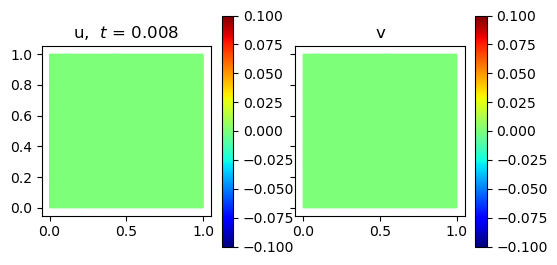

In [12]:
import skfem
import numpy as np
from skfem import MeshTri
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial import distance
from scipy.sparse.linalg import splu
from scipy.sparse import csc_matrix
from skfem.visuals.matplotlib import plot
from skfem.models.poisson import laplace, mass

# Function to generate boundary points
def generate_boundary_points(num_points_per_side):
    points = []
    for i in range(num_points_per_side):
        t = i / (num_points_per_side - 1)
        points.append([t, 0])
        points.append([t, 1])
        points.append([0, t])
        points.append([1, t])
    return np.array(points)

# Function to generate interior points
def generate_interior_points(num_points, minimum_distance, boundary_points):
    points = boundary_points.tolist()
    while len(points) < num_points:
        point = np.random.rand(2)
        if all(distance.euclidean(point, p) >= minimum_distance for p in points):
            points.append(point)
    return np.array(points)

# Generate points and mesh
num_boundary_points_per_side = 50  
num_points = 1200
minimum_distance = 0.0225
boundary_points = generate_boundary_points(num_boundary_points_per_side)
points = generate_interior_points(num_points, minimum_distance, boundary_points)
tri = Delaunay(points)
mesh = MeshTri(points.T, tri.simplices.T)

element = skfem.ElementTriP1()
basis = skfem.Basis(mesh, element)

# Define constants for Navier-Stokes
nu = 0.01  # Kinematic viscosity
dt = 0.004  # Time step

# Initialize velocity and pressure fields
u = np.zeros(basis.N)
v = np.zeros(basis.N)
p = np.zeros(basis.N)

# Define matrices for the Navier-Stokes solver
L = skfem.asm(laplace, basis)
M = skfem.asm(mass, basis)

theta = 0.5  # Crank-Nicolson method
A_u = M + theta * L * nu * dt
B_u = M - (1 - theta) * L * nu * dt
A_v = M + theta * L * nu * dt
B_v = M - (1 - theta) * L * nu * dt

# Convert to CSC format
A_u_csc = csc_matrix(A_u)
A_v_csc = csc_matrix(A_v)

epsilon = 1e-10
A_u_csc += epsilon * np.eye(A_u_csc.shape[0])
A_v_csc += epsilon * np.eye(A_v_csc.shape[0])

# Apply boundary conditions to make matrices invertible
boundary_dofs = basis.get_dofs().flatten()
A_u_csc[boundary_dofs, boundary_dofs] += 1e10
A_v_csc[boundary_dofs, boundary_dofs] += 1e10

# Perform factorization
backsolve_u = splu(A_u_csc.T).solve
backsolve_v = splu(A_v_csc.T).solve

# Custom function to compute the divergence
def compute_divergence(basis, u, v):
    from skfem import BilinearForm

    @BilinearForm
    def div_u(u, v, w):
        return u.grad[0]

    @BilinearForm
    def div_v(v, w, u):
        return v.grad[1]

    div_u_matrix = skfem.asm(div_u, basis)
    div_v_matrix = skfem.asm(div_v, basis)
    return div_u_matrix @ u + div_v_matrix @ v

# Define the Navier-Stokes solver function
def navier_stokes(u, v, p, dt):
    u_star = backsolve_u(B_u @ u)
    v_star = backsolve_v(B_v @ v)
    
    # Apply boundary conditions (simple zero Dirichlet for example)
    u_star[boundary_dofs] = 0
    v_star[boundary_dofs] = 0
    
    # Pressure correction (using a simple Poisson equation for incompressibility)
    div_star = compute_divergence(basis, u_star, v_star)
    rhs_p = (1 / dt) * div_star
    p = splu(csc_matrix(L + 1e10 * np.eye(L.shape[0]))).solve(rhs_p)
    
    return u, v, p

# Display the simulation results
def disp(mesh, u, v, basis, t):
    fig, axarr = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
    ax0 = axarr[0]
    ax1 = axarr[1]
    ax0.set_aspect('equal')
    ax1.set_aspect('equal')
    ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax=ax0)
    ax_j1 = plot(mesh, v[basis.nodal_dofs.flatten()], shading='gouraud', ax=ax1)
    fig = ax0.get_figure()
    field0 = ax0.get_children()[0]
    field1 = ax1.get_children()[0]
    fig.colorbar(field0)
    fig.colorbar(field1)
    title = ax0.set_title(f'u,  $t$ = {t:.3f}')
    title = ax1.set_title(f'v')

# Simulation loop
for i in range(3):
    u, v, p = navier_stokes(u, v, p, dt)

# Display results
disp(mesh, u, v, basis, i * dt)
